In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob
import scipy.stats
from IPython.display import Video, display, HTML
sns.set()

def read_csvx(path, *args, **kwargs):
    try:
        return pd.read_csv(str(path) +'.gz', *args, **kwargs)
    except Exception as e:
        return pd.read_csv(str(path), *args, **kwargs)

def followorbit(vals, path):
    out = []
    for n in range(100):
        closest05 = np.clip(round(path[n] * 2) / 2, 0, 10)
        rank = vals.query(f'nbopp == {n} and othercoop == {closest05}')['rank'].values[0]
        out.append(rank)
    return np.array(out)

import re
def gethighest(vals, prefix="analysis_log_"):
        m = np.argmax([int(re.search(f'{prefix}(\d+)', val).group(1)) for val in vals])
        return vals[m]

def readparams(file):
    params = {} 
    with open(file) as f:
        for line in f:
            line = line[:-1]  # remove \n
            if not line or line.startswith('#') or line.startswith('import'):
                continue
            key, val = line.split('=')
            if val.lower() == 'true' or val.lower() == 'false':
                params[key] = val.lower() == 'true'
            else:
                try:
                    params[key] = float(val)
                except ValueError:
                    params[key] = val
    return params

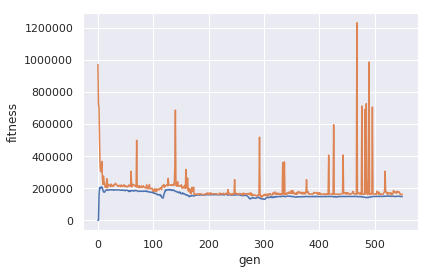

Cannot load vid
cannot load analysis log


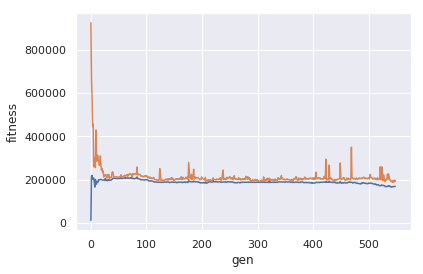

Cannot load vid
cannot load analysis log


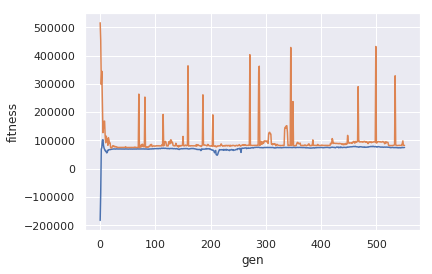

Cannot load vid
cannot load analysis log


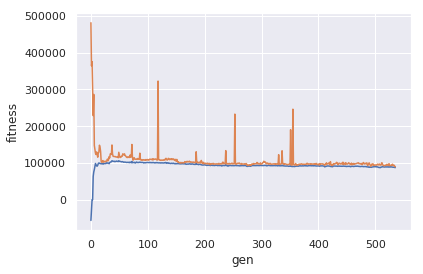

Cannot load vid
cannot load analysis log


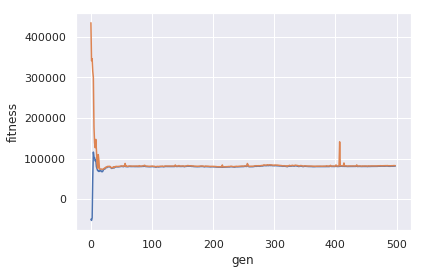

Cannot load vid
cannot load analysis log


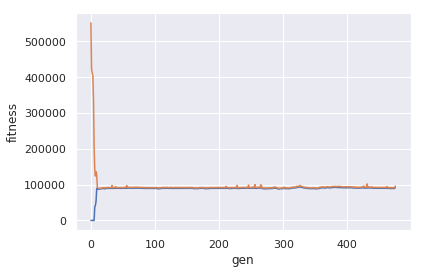

Cannot load vid
cannot load analysis log


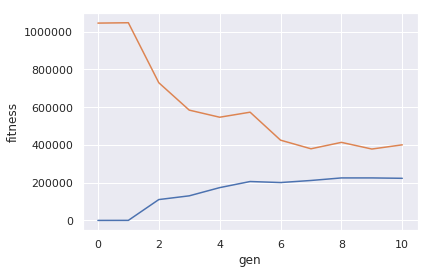

Cannot load vid
cannot load analysis log


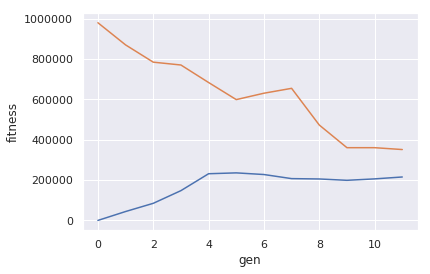

Cannot load vid
cannot load analysis log


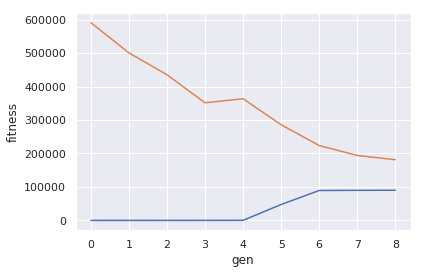

Cannot load vid
cannot load analysis log


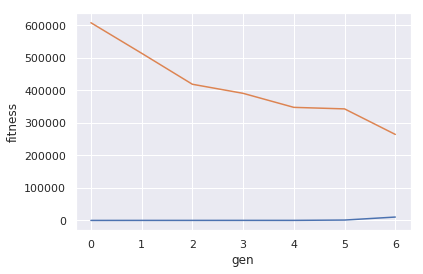

Cannot load vid
cannot load analysis log


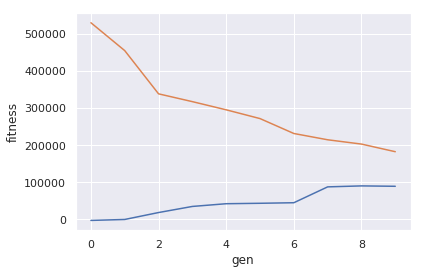

Cannot load vid
cannot load analysis log


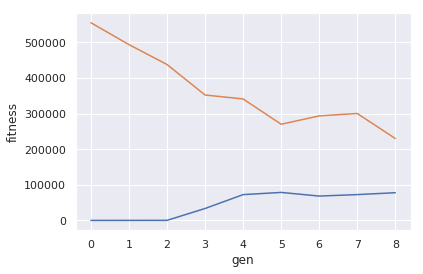

Cannot load vid
cannot load analysis log


In [2]:
showdecisionmap = False
paths = "../../../../logs/lions-maxtwo*-2019-06-14-*/**/rep00/"
#path = "/data/log/tournamentnofrichardpayofflongev/rep00/"
for path in sorted(glob.glob(paths, recursive=True)):
    display(HTML(f'<h3>{path}</h3>'))
    try:
        fit = read_csvx(path + "fitnesslog.txt", delimiter="\t")
        fit = fit.groupby(['gen', 'ind'], as_index=False).sum()
        plt.figure()
        sns.lineplot(y='fitness', x='gen', data=fit, ci=None, estimator='median')
        sns.lineplot(y='fitness', x='gen', data=fit, ci=None, estimator='max')
        #sns.lineplot(y='fitness', x='gen', data=fit, ci=None, estimator='min')
        plt.show()
    except Exception:
        print('Cannot load fitness')
    # Video
    try:
        vid = Video(gethighest(glob.glob(path+'/mov_*.mp4')))
        display(vid)
    except Exception:
        print('Cannot load vid')
    try:
        high = gethighest(glob.glob(path+'/analysis_log_*'));
    except Exception:
        print('cannot load analysis log')
        continue
    print(high)
    df = read_csvx(high, delimiter="\t")
    df['rank'] = scipy.stats.rankdata(df['score'])
    for ind in df['ind'].unique():
        neutral = df.query(f'ind == {ind} and owncoop == 5 and cost == 1 and nbopp == 0 and othercoop == 0').median()['rank']
        df.loc[df['ind'] == ind, 'normrank'] = df.loc[df['ind'] == ind, 'rank'] - neutral 
    #plt.figure(figsize=(20, 5))
    #sns.lineplot(x='nbopp', y='owncoop', units='ind', data=df.query('othercoop == 0 and cost == 1'), estimator=None, legend='full', alpha=0.01)
    #sns.lineplot(x='nbopp', y='owncoop', data=df.query('othercoop == 0 and cost == 1'), estimator=np.median, legend='full', color="blue")

    #plt.show()
    try:
        logall = read_csvx(gethighest(glob.glob(path + 'logall*'), 'logall_'), delimiter="\t")
    except Exception as e:
        print(e)
        continue
    meancoop = logall.query('nbOnOpp == 2').groupby(['id'], as_index=False).mean()
    meancoop['rep'] = 0
    totmeancoop = [meancoop]

    params = readparams(glob.glob(path + 'properties*')[0])
    logall['ess'] = params['meanA'] / logall['nbOnOpp']
    ess2 = params['meanA'] / 2
    so2 = params['meanA'] + params['b'] - (params['b'] /2)
    logall['so'] = params['meanA'] + params['b'] - (params['b'] /logall['nbOnOpp'])
    logall['oppId'] = logall['oppId'].astype('category')

    i = 1
    stop = 1
    while i < stop:
        try:
            nlogall = read_csvx(gethighest(glob.glob(path + f'../rep{i:02}/logall*'), 'logall_'), delimiter="\t")
        except Exception as e:
            print(f'break at {i}')
            break
        meancoop = nlogall.query('nbOnOpp == 2').groupby(['id'], as_index=False).mean()
        meancoop['rep'] = i
        totmeancoop.append(meancoop)
        i += 1
    dftotmeancoop = pd.concat(totmeancoop)
    del totmeancoop
    # Coop corr
    plt.figure(figsize=(5, 5))
    
    #logall[['previt', 'prevother', 'prevoppid']] = logall.shift(periods=logall['id'].max()+1)[['iter', 'otherCoop', 'oppId']]
    #sns.regplot('curCoopNoCoef', 'otherCoop', logall.query('nbOnOpp == 2 and prevother == otherCoop and oppId == prevoppid').groupby(['id']).mean())
    sns.regplot('curCoopNoCoef', 'otherCoop', dftotmeancoop)

    plt.ylim(ess2 - 0.5, so2 + 0.5)
    plt.axhline(ess2)
    plt.axhline(so2)
    plt.show()
    
    if showdecisionmap:
        for i in [9, 14]:
            plt.figure(figsize=(20, 5))
            sns.heatmap(df.query(f'ind == {i} and cost == 0 and nbopp == 1').pivot_table('normrank', 'othercoop', 'owncoop'), center=0)
            plt.title('On opp')
            plt.show()
            plt.figure(figsize=(20, 5))
            sns.heatmap(df.query(f'ind == {i} and cost == 1 and nbopp == 1').pivot_table('normrank', 'othercoop', 'owncoop'), center=0)
            plt.title('move')
            plt.show()

In [ ]:
for ind in df['ind'].unique():
    neutral = df.query(f'ind == {ind} and owncoop == 5 and cost == 1 and nbopp == 0 and othercoop == 0').median()['rank']
    df.loc[df['ind'] == ind, 'normrank'] = df.loc[df['ind'] == ind, 'rank'] - neutral 
#df = df.merge(means_stds,on='indx')
#df['a0_normalized'] = (df['a0'] - df['mean']) / df['std']